# Notebook


In [96]:
import oandapyV20.endpoints.instruments as instruments
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.trades as trades
import pandas as pd
import oandapyV20 

import numpy as np
import seaborn as sns 
import quantstats as qs 
import datetime 
import matplotlib.pyplot as plt 
%matplotlib inline 
import yfinance as yf 



In [97]:
# Account information
OANDA_ACCESS_TOKEN = "987464a00c47a9b186fcc7a93a9404a6-bf2ecb97ae681e4edeb529adef404b09"
ACCOUNT_ID = "101-001-8028197-001"
access_token = OANDA_ACCESS_TOKEN
accountID = ACCOUNT_ID
client = oandapyV20.API(access_token=access_token)
API_KEY = access_token

In [98]:
# Instrument (USDJPY)
instrument = "EUR_USD"

# Granularity (daily)
granularity = "D"



In [99]:

# OANDA API connection setup
api = oandapyV20.API(access_token=API_KEY, environment="practice")

# Function to fetch historical data
def get_historical_data(instrument, granularity, start, end):
    params = {
        "granularity": granularity,
        "from": start,
        "to": end,
    }
    request = instruments.InstrumentsCandles(instrument=instrument, params=params)
    response = api.request(request)
    data = response['candles']
    ohlc_data = [{'time': candle['time'], 'open': float(candle['mid']['o']), 'high': float(candle['mid']['h']),
                  'low': float(candle['mid']['l']), 'close': float(candle['mid']['c'])} for candle in data]
    df = pd.DataFrame(ohlc_data)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

# Define the instrument, granularity, and date range
instrument = 'EUR_USD'
granularity = 'D'  # Daily data
start_date = '01-01-2022'
end_date = '01-01-2023'

# Fetch historical data
historical_data = get_historical_data(instrument, granularity, start_date, end_date)
data = historical_data
# Print the fetched data
#print(historical_data)

data.index= data.index.tz_localize(None)  # otherwise Quanstats will not be able to convert timezone or compare benchmark to strategy




display (data)

,open,high,low,close
time,,,,
2022-01-02 22:00:00,1.13725,1.13795,1.12798,1.12974
2022-01-03 22:00:00,1.12965,1.13226,1.12724,1.12864
2022-01-04 22:00:00,1.12863,1.13465,1.12772,1.13129
2022-01-05 22:00:00,1.13130,1.13318,1.12846,1.12984
2022-01-06 22:00:00,1.12967,1.13648,1.12900,1.13616
...,...,...,...,...
2022-12-22 22:00:00,1.05964,1.06332,1.05868,1.06162
2022-12-26 22:00:00,1.06357,1.06696,1.06115,1.06380
2022-12-27 22:00:00,1.06408,1.06746,1.06067,1.06122


In [100]:
# Add on to Data Dataframe for Profit, Units, Balance...

# Pivot calculation 
pivot= ((data['open']+data ['low'] + data['close'])/3)
data['pivot'] = pivot          
data['previous_pivot'] = data['pivot'].shift(1)

# Create a Signal column with 1, whenever the previous pivot is less than current open 
data.loc[data['previous_pivot'] > data['open'], 'Signal'] = 1

#End Algo Note ---- use from this point above for algorithm code 



# Start Backtest 

# Once signal 1 is created at the open, buy the open of that same day.  Sell the close.    

# Calculate daily range 
data['range']= data['high']-data['low']

# Calculate daily change 
data['change']= data['close']-data['open']

# Calculate profit
data['profit'] = data.apply(lambda row: row['change'] * 100 if row['Signal'] == 1 else 0, axis=1)

profit = data ['profit']

# Initial Balance, Cumulative Profit, Balance 
initial_balance = 10000
data['cumulative_profit'] = data['profit'].cumsum()
data['balance'] = initial_balance + data['cumulative_profit']


# Calculate 'returns' column
data['returns'] = data['profit'] / data['balance']

display(data)


,open,high,low,close,pivot,previous_pivot,Signal,range,change,profit,cumulative_profit,balance,returns
time,,,,,,,,,,,,,
2022-01-02 22:00:00,1.13725,1.13795,1.12798,1.12974,1.131657,NaN,NaN,0.00997,-0.00751,0.000,0.000,10000.000,0.000000
2022-01-03 22:00:00,1.12965,1.13226,1.12724,1.12864,1.128510,1.131657,1.0,0.00502,-0.00101,-0.101,-0.101,9999.899,-0.000010
2022-01-04 22:00:00,1.12863,1.13465,1.12772,1.13129,1.129213,1.128510,NaN,0.00693,0.00266,0.000,-0.101,9999.899,0.000000
2022-01-05 22:00:00,1.13130,1.13318,1.12846,1.12984,1.129867,1.129213,NaN,0.00472,-0.00146,0.000,-0.101,9999.899,0.000000
2022-01-06 22:00:00,1.12967,1.13648,1.12900,1.13616,1.131610,1.129867,1.0,0.00748,0.00649,0.649,0.548,10000.548,0.000065
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 22:00:00,1.05964,1.06332,1.05868,1.06162,1.059980,1.059220,NaN,0.00464,0.00198,0.000,-4.472,9995.528,0.000000
2022-12-26 22:00:00,1.06357,1.06696,1.06115,1.06380,1.062840,1.059980,NaN,0.00581,0.00023,0.000,-4.472,9995.528,0.000000
2022-12-27 22:00:00,1.06408,1.06746,1.06067,1.06122,1.061990,1.062840,NaN,0.00679,-0.00286,0.000,-4.472,9995.528,0.000000


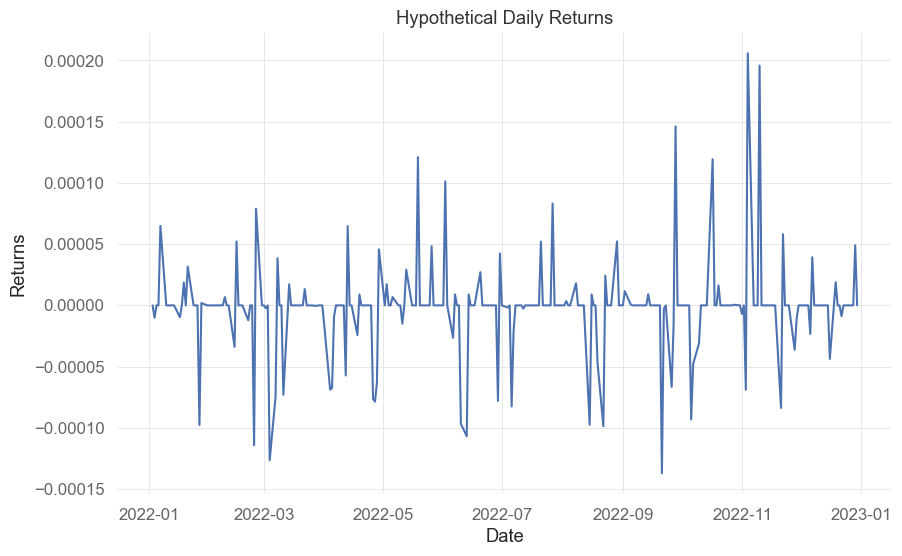

In [101]:
# Create the line chart
sns.lineplot(x="time", y="returns", data=data)

# Customize the plot
plt.title("Hypothetical Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.grid(True)

# Show the plot
plt.show()


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-03   2022-01-03
End Period                 2022-12-29   2022-12-29
Risk-Free Rate             0.0%         0.0%
Time in Market             35.0%        35.0%

Cumulative Return          -6.27%       -0.04%
CAGR﹪                     -4.43%       -0.03%

Sharpe                     -0.51        -0.64
Prob. Sharpe Ratio         26.61%       26.32%
Smart Sharpe               -0.51        -0.63
Sortino                    -0.55        -0.91
Smart Sortino              -0.55        -0.9
Sortino/√2                 -0.39        -0.64
Smart Sortino/√2           -0.39        -0.64
Omega                      0.83         0.83

Max Drawdown               -13.34%      -0.09%
Longest DD Days            348          338
Volatility (ann.)          11.06%       0.06%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar            

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-26,2022-10-09,2022-12-29,338,-0.091467,-0.088874
2,2022-01-16,2022-01-16,2022-01-17,2,-0.000960,NaN


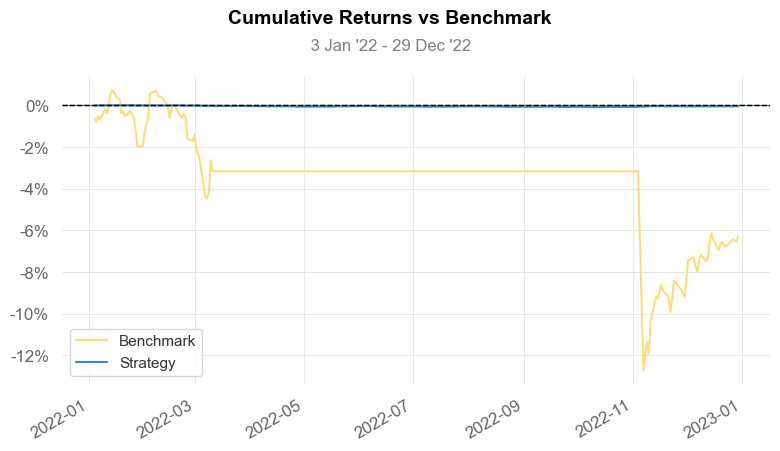

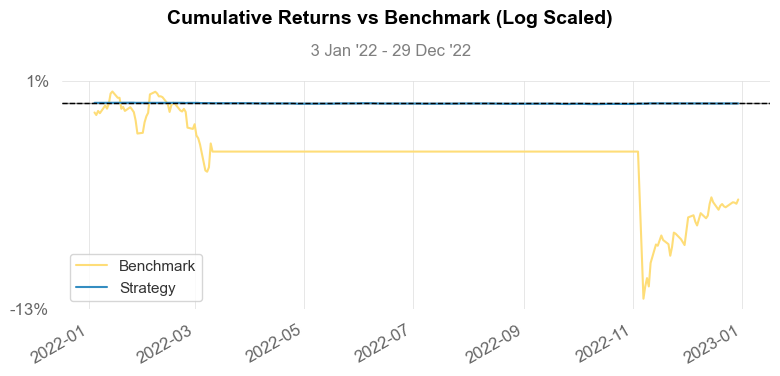

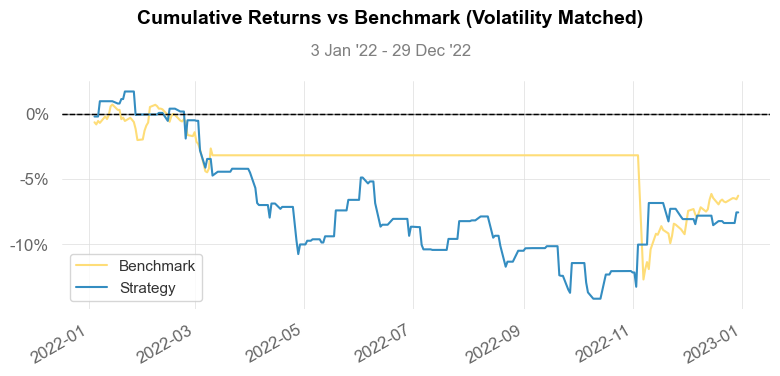

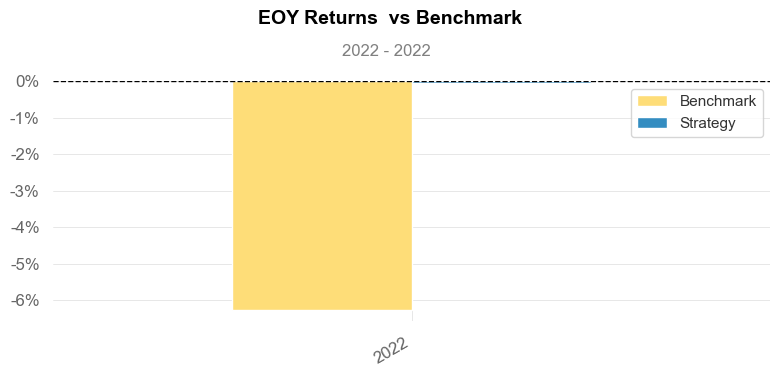

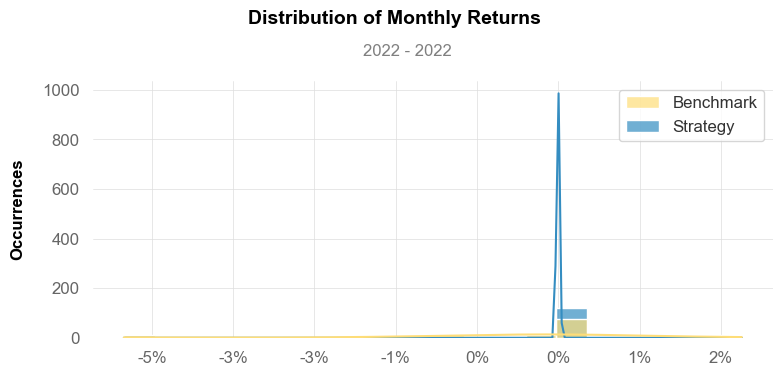

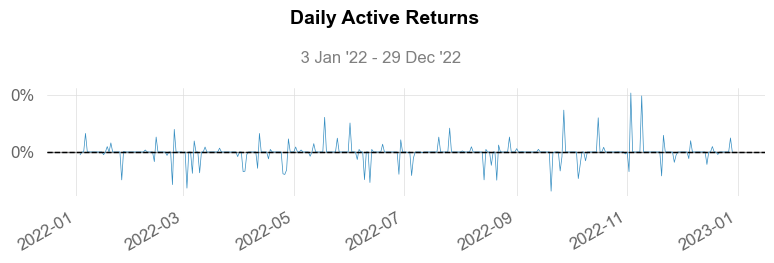

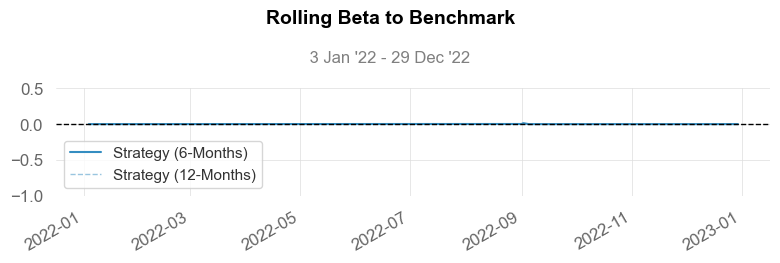

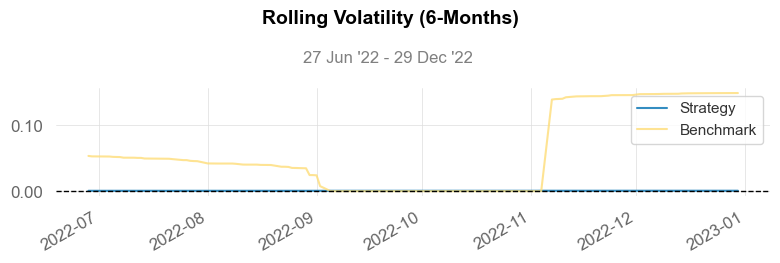

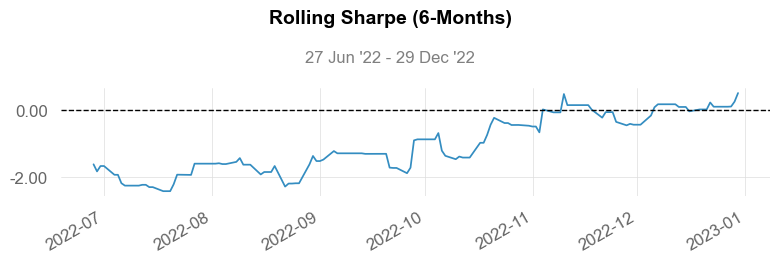

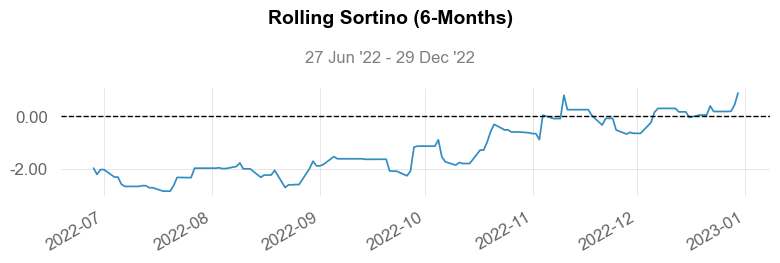

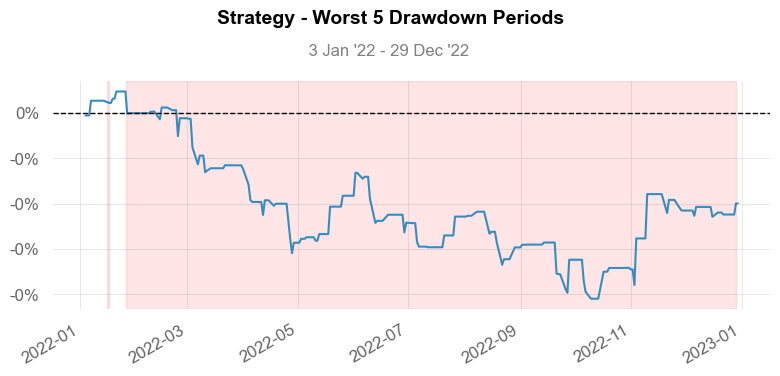

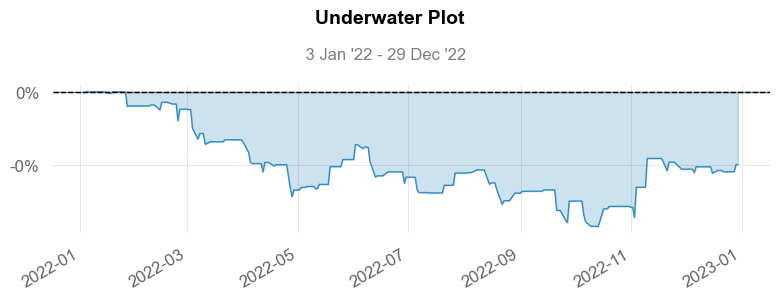

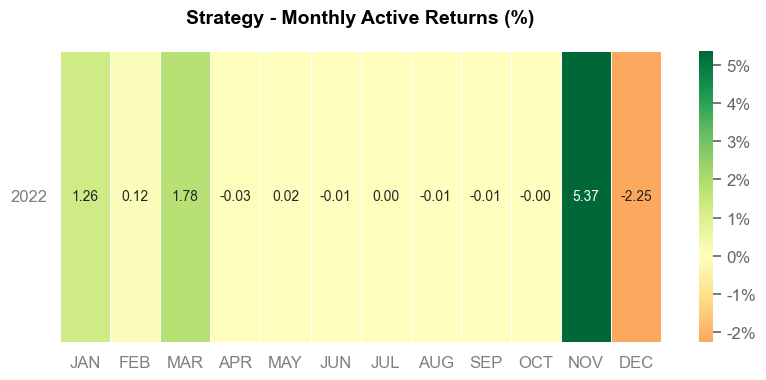

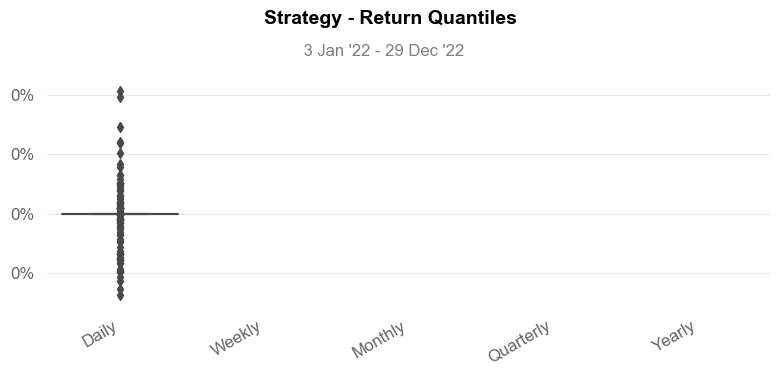

In [102]:
# Load returns, without having to convert to a series 
returns_series = data['returns']



benchmark = qs.utils.download_returns('eurusd=X') # note ticker format 
qs.reports.full(returns_series , benchmark)
#qs.reports.full(benchmark)
# Html Tearsheet
#qs.reports.html(returns_series , benchmark=benchmark)